In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import incremental_transformer as it
from forecasting import shift_comparison_predictor as shift_pred
from forecasting import simple_comparison_predictor as simple_pred
import pandas as pd
import normalization as norm
import numpy as np
%matplotlib inline

In [3]:
import datetime as dt

In [4]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 7, 5

In [5]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

In [6]:
mpl.rcParams['font.sans-serif'].insert(0, 'Liberation Sans')
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.family'] = 'sans-serif'

In [7]:
import seaborn as sns

In [8]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [9]:
def mape(prediction, target):
    return np.mean(np.abs((target - prediction) / target)) * 100

In [10]:
def smape(prediction, target):
    return np.mean(np.abs(target - prediction) / np.abs(target + prediction)) * 200

In [11]:
def mae(prediction, target):
    return np.mean(np.abs(target - prediction)) * 100

In [12]:
def mdae(prediction, target):
    return np.median(np.abs(target - prediction)) * 100

In [15]:
# dataset obtained from http://www.elia.be/en/grid-data/data-download
filename = "../data/belgium.csv"
data = pd.DataFrame.from_csv(filename, index_col=[0])

In [16]:
len(data)

374496

In [17]:
data.head(5)

,value
date,
2005-01-01 00:15:00,9503607.0
2005-01-01 00:30:00,9357379.0
2005-01-01 00:45:00,9181671.0
2005-01-01 01:00:00,9067683.0
2005-01-01 01:15:00,9007000.0


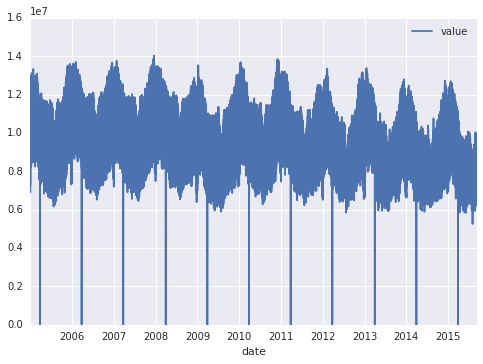

In [19]:
data.plot()

In [20]:
def from_timestamp(x):
    return x.to_datetime()
dateconv = np.vectorize(from_timestamp)

In [21]:
dates = map(from_timestamp, data.index)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  """Entry point for launching an IPython kernel.


In [23]:
data.index = dates

In [24]:
data.head()

,value
2005-01-01 00:15:00,9503607.0
2005-01-01 00:30:00,9357379.0
2005-01-01 00:45:00,9181671.0
2005-01-01 01:00:00,9067683.0
2005-01-01 01:15:00,9007000.0


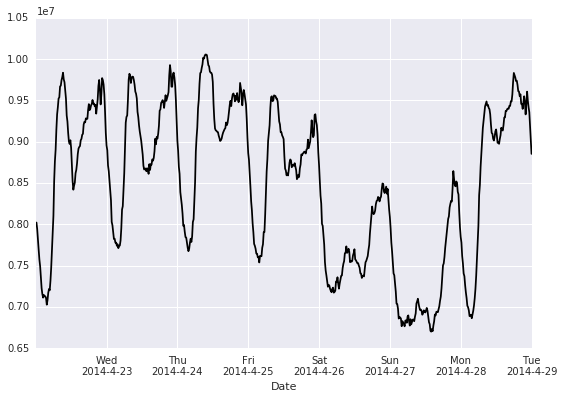

In [26]:
start = 96*3398
subsample = data[start:(start+96*7)]
dates_subsample = dates[start:(start+96*7)]

plt.plot(dates_subsample, subsample['value'], color='black')
ax=plt.gca()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%a\n%Y-%-m-%d'))

plt.tight_layout()
ax.set_xlabel('Date')
plt.savefig('ukazka.png', dpi=300)

# PAA

In [27]:
def paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju spojit    
    """
    sub_series = series[0:((len(series) / coefficient) * coefficient)] # skratenie na nasobok koeficientu
    composite_list = [sub_series[x:x+coefficient] for x in range(0, len(sub_series),coefficient)] # rozsekanie na kusky dlzku koeficientu
    result = [x.mean() for x in composite_list]
    return sub_series, pd.Series(result) # vracia aj skratenu hodnotu a aj paa reprezentaciu

In [28]:
def un_paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju vytvorit    
    """
    array = []
    for x in series:
        array += ([x] * coefficient)
    return pd.Series(array)

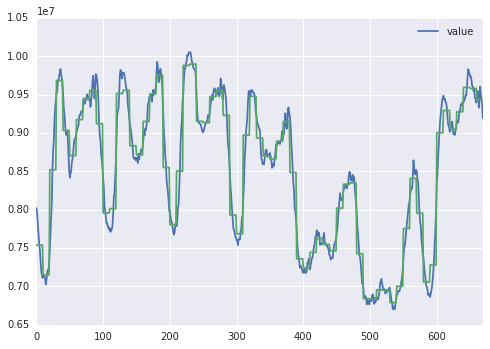

In [29]:
coefficient = 10
subseries, result = paa(subsample.value, coefficient)
reconstructed = un_paa(result, coefficient)
subseries.reset_index().plot()
reconstructed.plot()

In [30]:
rmse(np.array(reconstructed), np.array(subseries))

223171.22856934048

In [31]:
rmses = []
coefficients = []
sizes = []

for coefficient in xrange(2, 96):
    subseries, result = paa(sample_data.value, coefficient)
    reconstructed = un_paa(result, coefficient)
    rmses.append(rmse(np.array(reconstructed), np.array(subseries)))
    sizes.append(int(len(sample_data) / coefficient))
    coefficients.append(coefficient)

In [32]:
paa_results2 = pd.DataFrame()
paa_results2['Transformed data size'] = sizes
# paa_results['coefficient'] = coefficients
paa_results2['RMSE'] = rmses
paa_results2.index = coefficients

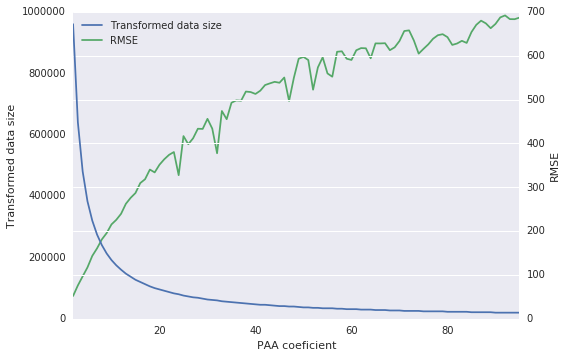

In [33]:
ax = paa_results2.plot(secondary_y=['Transformed data size'], mark_right=False)
ax.set_ylabel('Transformed data size')
ax.set_xlabel('PAA coeficient')
ax.right_ax.set_ylabel('RMSE')

# ISC representation

## Reconstruction

In [34]:
normalization = norm.ZNormalization()
# Train normalization coefficients on first week of data
normalization.train_coefficients(data.value[0:(96*7)])

In [35]:
trans = it.IncrementalTransformer(96, 96, 2.0, normalization=normalization)
symbols = trans.transform(subsample.value)

In [39]:
result = trans.reconstruct(symbols, 96)

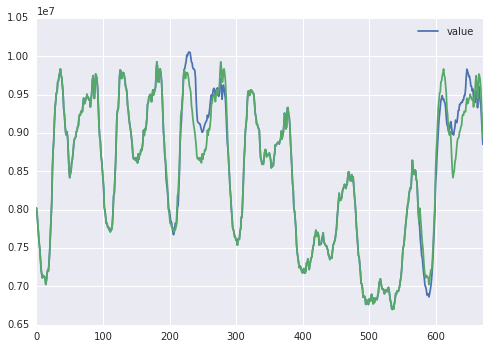

In [40]:
subsample.reset_index().plot()
pd.Series(result).plot()

## Properties with increasing amount of processed datazavyslost od mnozstva spracovanych dat

In [43]:
sample_data = data
# sample_data = data[0:(96*7*100)] # 100 weeks worth of data

In [44]:
coefficient = 7 # PAA coefficient

step = 96 * 7

isc_rmse = []
isc_smape = []
isc_size = []
paa_rmse = []
paa_smape = []
paa_size = []
data_sizes = []

normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.value[0:(96*7)])

In [45]:
symbols = []
trans = it.IncrementalTransformer(96, 96, 2.4, normalization=normalization) # povodna limit_distance bola 2.3 # pri 2.5 je pekna velkost abecedy ale prilis velka chybovost pri coeficiente 7
for data_size in xrange(1,int(len(sample_data)/step)):
    subsample = sample_data.value[0:(data_size * step)]
    data_sizes.append(data_size * step)
    
    symbols = symbols + trans.transform(subsample[-step:])
    isc_result = trans.reconstruct(symbols, 96)
    
    isc_rmse.append(rmse(isc_result, subsample[0:(len(isc_result))]))
    isc_smape.append(smape(isc_result, subsample[0:(len(isc_result))]))
    isc_size.append((len(symbols) * 3) + (trans.symbol_alphabet.size() * 96))
#     print(len(set([symbol.unscaled.id for symbol in symbols])), trans.symbol_alphabet.size())
    paa_subseries, paa_result = paa(subsample, coefficient)
    paa_reconstructed = un_paa(paa_result, coefficient)
    paa_rmse.append(rmse(np.array(paa_reconstructed), np.array(paa_subseries)))
    paa_smape.append(smape(np.array(paa_reconstructed), np.array(paa_subseries)))
    paa_size.append(int(len(subsample) / coefficient))
    
    normalization.train_coefficients(subsample[-step:]) 

In [46]:
all_results = pd.DataFrame()
all_results['PAA data size'] = paa_size
all_results['PAA RMSE'] = paa_rmse
all_results['PAA SMAPE'] = paa_smape
all_results['ISC data size'] = isc_size
all_results['ISC RMSE'] = isc_rmse
all_results['ISC SMAPE'] = isc_smape
all_results['Amount of processed data'] = data_sizes

In [ ]:
all_results.to_csv('paa_isc_belgium.csv')
# all_results = pd.read_csv('paa_isc_belgium.csv')

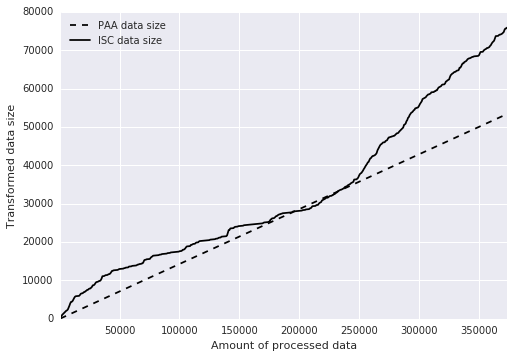

In [48]:
ax = all_results.plot(x='Amount of processed data', y=['PAA data size', 'ISC data size'], style=['--','-'], color=['black', 'black'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')

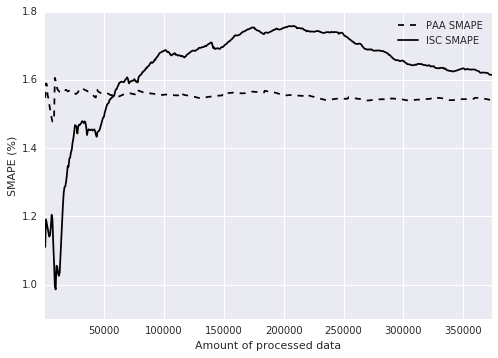

In [49]:
ax = all_results.plot(x='Amount of processed data', y=['PAA SMAPE', 'ISC SMAPE'], style=['--','-'], color=['black', 'black'])
ax.set_ylabel('SMAPE (%)')
ax.set_xlabel('Amount of processed data')
plt.savefig('pokus.png',dpi=600, bbox_inches='tight') 

In [50]:
# posledna hodnota rekonstrukcnej chyby
all_results['ISC SMAPE'][len(all_results['ISC SMAPE'])-1]

1.6153625255842037

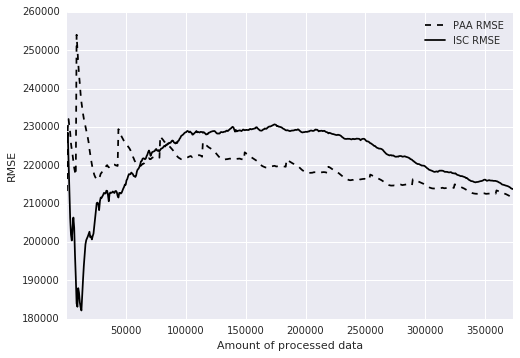

In [51]:
ax = all_results.plot(x='Amount of processed data', y=['PAA RMSE', 'ISC RMSE'], style=['--','-'], color=['black', 'black'])
ax.set_ylabel('RMSE')
ax.set_xlabel('Amount of processed data')
plt.savefig('pokus.png',dpi=600, bbox_inches='tight') 

In [52]:
all_results2 = pd.DataFrame()
all_results2['PAA data size'] = paa_size
all_results2['ISC symbol size'] = 3 * all_results['Amount of processed data'] / 96
all_results2['ISC alphabet size'] = all_results['ISC data size'] - (3 * all_results['Amount of processed data'] / 96)
all_results2['ISC data size'] = isc_size
all_results2['Amount of processed data'] = all_results['Amount of processed data']

In [53]:
all_results2['Date'] = data.index[0::(96*7)][2:]

In [54]:
len(all_results)

556

In [55]:
len(all_results2)

556

In [56]:
len(data.index[0::(96*7)][2:])

556

In [57]:
len(data) / len(all_results2) / 96

7

In [58]:
all_results2.head()

,PAA data size,ISC symbol size,ISC alphabet size,ISC data size,Amount of processed data,Date
0,96,21.0,384.0,405,672,2005-01-15 00:15:00
1,192,42.0,672.0,714,1344,2005-01-22 00:15:00
2,288,63.0,960.0,1023,2016,2005-01-29 00:15:00
3,384,84.0,1152.0,1236,2688,2005-02-05 00:15:00
4,480,105.0,1344.0,1449,3360,2005-02-12 00:15:00


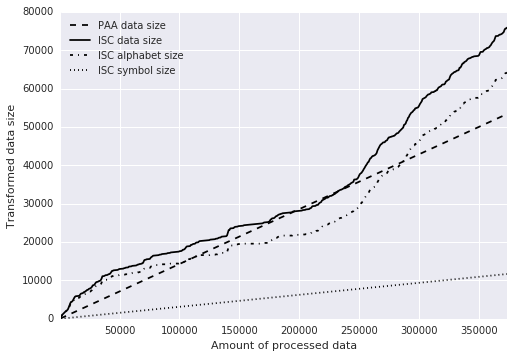

In [59]:
ax = all_results2.plot(x='Amount of processed data', y=['PAA data size', 'ISC data size', 'ISC alphabet size', 'ISC symbol size'],
                      style=['--', '-', '-.',':'], color=['black','black','black','black'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')
plt.savefig('pokus.png',dpi=600, bbox_inches='tight') 